
Running experiment with SGD, lr=0.01, bs=8, shuffle=random


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Training:   0%|          | 0/125 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/5 - Train Loss: 7.5104, Val Loss: 5.6749, Val Perplexity: 291.47


Epoch 2/5 - Train Loss: 5.0499, Val Loss: 3.6726, Val Perplexity: 39.35


Epoch 3/5 - Train Loss: 3.9660, Val Loss: 3.1468, Val Perplexity: 23.26


Epoch 4/5 - Train Loss: 3.5441, Val Loss: 3.0063, Val Perplexity: 20.21


Epoch 5/5 - Train Loss: 3.3889, Val Loss: 2.9815, Val Perplexity: 19.72
Estimating Hessian sharpness...


  0%|          | 0/20 [00:00<?, ?it/s]/home/jack/anaconda3/envs/cs439/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
100%|██████████| 3/3 [00:10<00:00,  3.53s/it]

Hessian λ_max: 39.4007
Sharpness: 262.69%


Measured relative loss increase: 0.05%
Predicted relative loss increase: 0.05%
Linear term: 5.8406e-03
Quadratic term (0.5 * eps^2 * lambda_max): 1.9700e-05


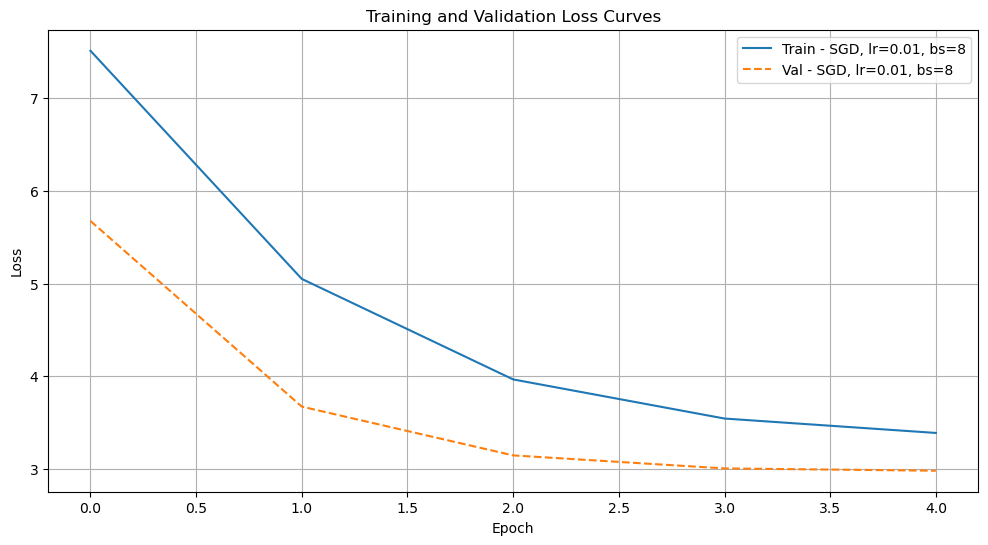

In [1]:
import torch
import numpy as np
import warnings

from optimization.experiments import run_experiment
from utils.config_loader import load_config
from utils.plots import plot_loss_curves

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*")

# Load config
config = load_config("config/base.yaml")

# Device setup
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define experiments
experiments = [
    {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'random'},
    # {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'sorted'},
]

# Initialize results list
results_list = []
    
# Run experiments
for exp in experiments:
    print(f"\nRunning experiment with {exp['optimizer_class'].__name__}, lr={exp['lr']}, bs={exp['batch_size']}, shuffle={exp['shuffle_mode']}")
    results = run_experiment(config, epochs=5, rand_dir=False, **exp)
    results_list.append(results)

# Plot loss curves for all experiments
plot_loss_curves(results_list)
